In [21]:
import pandas as pd
import json, random, torch, os, torchvision
from facenet_pytorch import InceptionResnetV1
from PIL import Image
from tqdm import tqdm

In [22]:
from mpl_toolkits import mplot3d

Try to make clusters out of the faces so they can be splitted later on between train and validation

**Extract embeddings and cluster faces**

In [23]:
pd.options.mode.chained_assignment = None  # default='warn'

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = InceptionResnetV1(pretrained='vggface2', device=device).eval()

In [25]:
base_df = pd.read_csv('datasets/full_chunk0.csv')
real = base_df.loc[base_df['label'] == 0]

In [26]:
real.drop(columns=['original'], inplace=True)
real.drop_duplicates(subset=['video', 'face_n', 'label'], inplace=True, ignore_index=True)

In [27]:
tf_img = lambda i: torchvision.transforms.ToTensor()(i).unsqueeze(0)

In [28]:
real['path'] = real.frame.map(lambda x: f'data/faces2/chunk0/{x}')

,video,frame,label,face_n,order,path
0,vpmyeepbep.mp4,vpmyeepbep_0_0.png,0,0,0,data/faces2/chunk0/vpmyeepbep_0_0.png
1,fzvpbrzssi.mp4,fzvpbrzssi_0_0.png,0,0,0,data/faces2/chunk0/fzvpbrzssi_0_0.png
2,syxobtuucp.mp4,syxobtuucp_0_0.png,0,0,0,data/faces2/chunk0/syxobtuucp_0_0.png
3,dhjnjkzuhq.mp4,dhjnjkzuhq_0_0.png,0,0,0,data/faces2/chunk0/dhjnjkzuhq_0_0.png
4,xcruhaccxc.mp4,xcruhaccxc_0_0.png,0,0,0,data/faces2/chunk0/xcruhaccxc_0_0.png
...,...,...,...,...,...,...
66,xdezcezszc.mp4,xdezcezszc_0_0.png,0,0,0,data/faces2/chunk0/xdezcezszc_0_0.png
67,gnmmhlbzge.mp4,gnmmhlbzge_0_0.png,0,0,0,data/faces2/chunk0/gnmmhlbzge_0_0.png
68,lsmnqsnqld.mp4,lsmnqsnqld_0_0.png,0,0,0,data/faces2/chunk0/lsmnqsnqld_0_0.png
69,yljecirelf.mp4,yljecirelf_0_0.png,0,0,0,data/faces2/chunk0/yljecirelf_0_0.png


In [29]:
real.shape

(71, 6)

In [30]:
faces = real.path.tolist()
embeddings = []

for face in faces:
    with torch.no_grad():
        embedding = resnet(tf_img(Image.open(face)).to(device)).cpu().tolist()[0]
    embeddings.append(embedding)

In [31]:
real['embeddings'] = pd.Series(embeddings)

**Primary Component Analysis (PCA)**

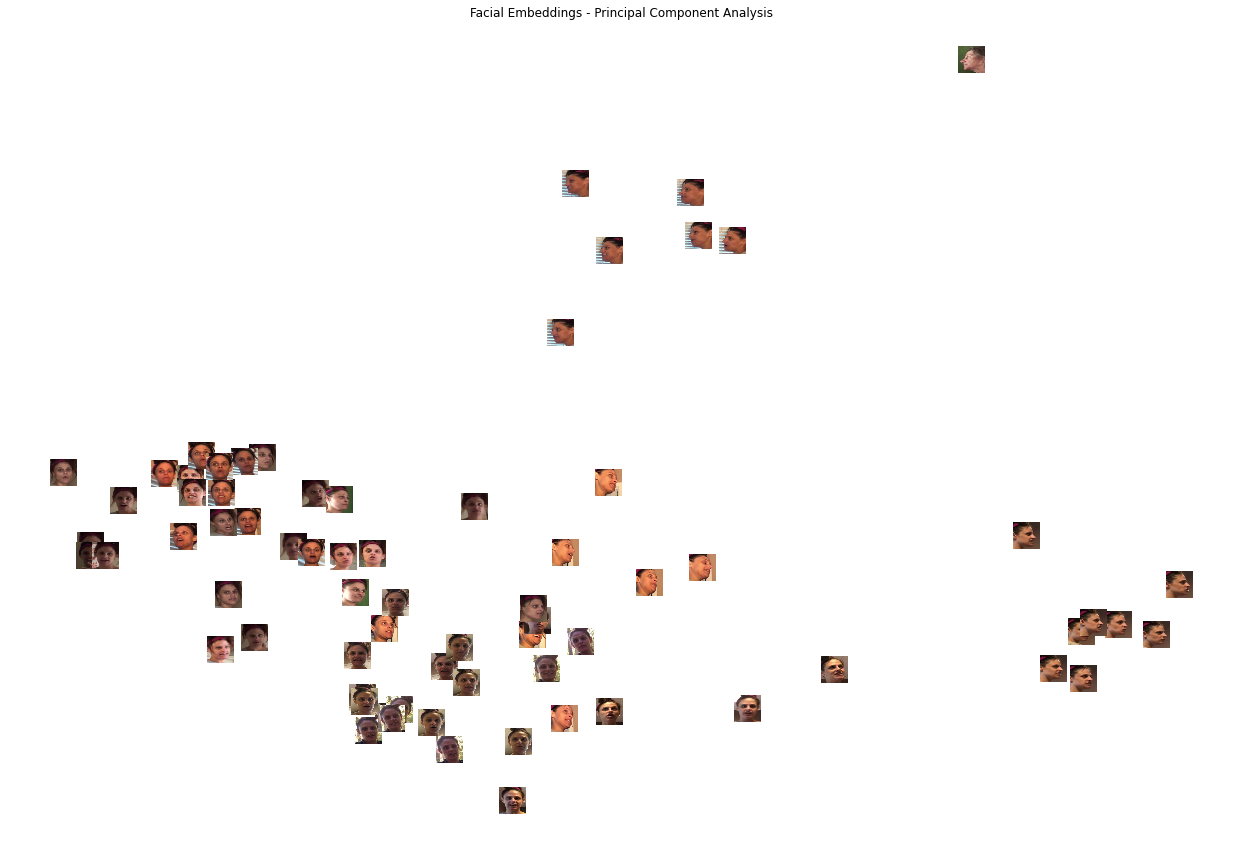

In [50]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def scatter_thumbnails(data, images, zoom=0.12, colors=None):
    assert len(data) == len(images)

    # reduce embedding dimentions to 2
    x = PCA(n_components=2).fit_transform(data) if len(data[0]) > 2 else data
        
    # create a scatter plot.
    f = plt.figure(figsize=(22, 15))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], s=4)
    _ = ax.axis('off')
    _ = ax.axis('tight')

    # add thumbnails :)
    for i in range(len(images)):
        image = plt.imread(images[i])
        im = OffsetImage(image, zoom=zoom)
        bboxprops = dict(edgecolor=colors[i]) if colors is not None else None
        ab = AnnotationBbox(im, x[i], xycoords='data', frameon=(bboxprops is not None), pad=0.02, bboxprops=bboxprops)
        ax.add_artist(ab)
    return ax

def scatter_thumbnails_3d(data, images, zoom=0.12, colors=None):
    assert len(data) == len(images)

    # reduce embedding dimentions to 2
    x = data #PCA(n_components=2).fit_transform(data) if len(data[0]) > 2 else data
        
    # create a scatter plot.
    f = plt.figure(figsize=(22, 15))
    ax = plt.axes(projection='3d')
    #ax = plt.subplot(aspect='equal')
    sc = ax.scatter3D(x[:,0], x[:,1], x[:,2], s=4)
    _ = ax.axis('off')
    _ = ax.axis('tight')

    # add thumbnails :)
    for i in range(len(images)):
        image = plt.imread(images[i])
        im = OffsetImage(image, zoom=zoom)
        bboxprops = dict(edgecolor=colors[i]) if colors is not None else None
        ab = AnnotationBbox(im, x[i], xycoords='data', frameon=(bboxprops is not None), pad=0.02, bboxprops=bboxprops)
        ax.add_artist(ab)
    return ax

_ = scatter_thumbnails(real.embeddings.tolist(), faces)
plt.title('Facial Embeddings - Principal Component Analysis')
plt.show()

In [51]:
%%time
from sklearn.manifold import TSNE
# PCA first to speed it up
x = PCA(n_components=50).fit_transform(real['embeddings'].tolist())
x = TSNE(perplexity=50, n_components=3).fit_transform(x)

_ = scatter_thumbnails_3d(x, faces, zoom=0.06)
plt.title('3D t-Distributed Stochastic Neighbor Embedding')
plt.show()

ValueError: too many values to unpack (expected 2)

<Figure size 1584x1080 with 1 Axes>

CPU times: user 2.11 s, sys: 639 ms, total: 2.74 s
Wall time: 875 ms


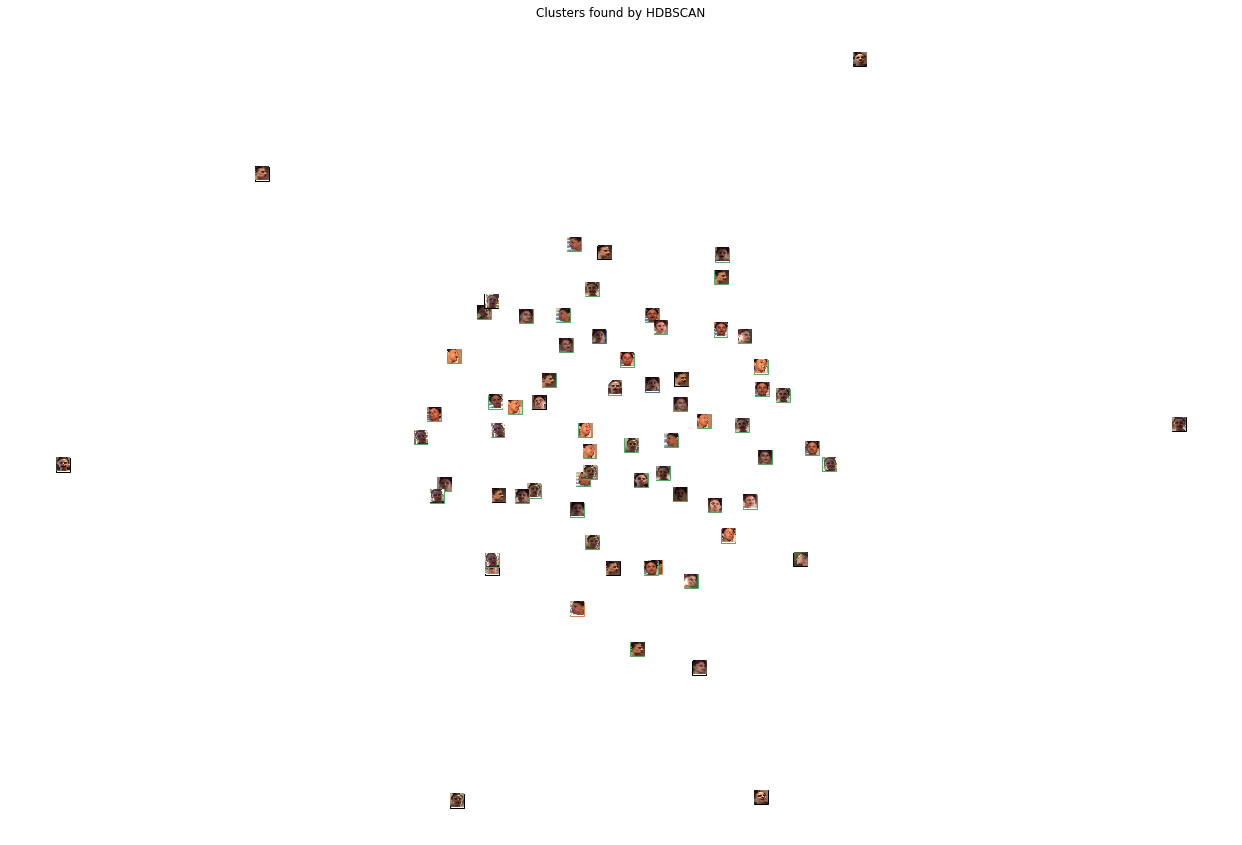

In [40]:
from sklearn import cluster
import hdbscan
def plot_clusters(data, algorithm, *args, **kwds):
    labels = algorithm(*args, **kwds).fit_predict(data)
    palette = sns.color_palette('deep', np.max(labels) + 1)
    colors = [palette[x] if x >= 0 else (0,0,0) for x in labels]
    ax = scatter_thumbnails(x, real.path.tolist(), zoom=0.06, colors=colors)
    plt.title(f'Clusters found by {algorithm.__name__}')
    return labels

clusters = plot_clusters(x, hdbscan.HDBSCAN, alpha=0.5, min_cluster_size=2, min_samples=1)
#clusters = plot_clusters(x, cluster.DBSCAN, n_jobs=-1, eps=2, min_samples=1)
real['cluster'] = clusters

In [76]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
res_df = df.drop(columns=['label', 'label2', 'embedding', 'path']).sort_values(by='cluster', kind='quicksort')

In [77]:
res_df.sort_values(by='cluster')

,video,cluster
3907,uqaaspbgtz.mp4,-1
23,gcdtglsoqj.mp4,-1
1098,uqzgyxstct.mp4,-1
25,upmgtackuf.mp4,-1
2189,ovxqacozqb.mp4,-1
...,...,...
2724,frwpjswdnr.mp4,1204
3254,uprxolxcqf.mp4,1204
2714,vgxfdvtnic.mp4,1204
3054,wlbspibmfg.mp4,1205


In [81]:
base_df.set_index(['video'])
v = res_df.set_index(['video'])

In [83]:
v.head(10)

,cluster
video,
uqaaspbgtz.mp4,-1
fwiyjcfwta.mp4,-1
vgorklvyph.mp4,-1
todvzqzwit.mp4,-1
egkaufznwj.mp4,-1
bspvtixfud.mp4,-1
baxkmsihqv.mp4,-1
anrgplirit.mp4,-1
dskfqergbt.mp4,-1


In [86]:
v[v.index == 'bgeacsngmi.mp4']

,cluster
video,
bgeacsngmi.mp4,-1


In [89]:
z = base_df.join(v, on='video').sort_values(by='cluster')
z['label'] = z['label2']
z.drop(columns=['label2'])

,Unnamed: 0,video,label,path,cluster
9687,9687,bgeacsngmi.mp4,0,data/faces/chunk6/bgeacsngmi_11_0.png,-1
1626,1626,rzljiqidhj.mp4,0,data/faces/chunk2/rzljiqidhj_0_0.png,-1
1627,1627,rzljiqidhj.mp4,0,data/faces/chunk2/rzljiqidhj_14_0.png,-1
12576,12576,yoqqryxlll.mp4,0,data/faces/chunk7/yoqqryxlll_1_0.png,-1
12577,12577,yoqqryxlll.mp4,0,data/faces/chunk7/yoqqryxlll_11_0.png,-1
...,...,...,...,...,...
12083,12083,yyaejjkbds.mp4,0,data/faces/chunk7/yyaejjkbds_31_0.png,1205
13444,13444,wlbspibmfg.mp4,1,data/faces/chunk7/wlbspibmfg_16_0.png,1205
13447,13447,wlbspibmfg.mp4,1,data/faces/chunk7/wlbspibmfg_12_0.png,1205
13446,13446,wlbspibmfg.mp4,1,data/faces/chunk7/wlbspibmfg_25_0.png,1205


In [103]:
res = z.drop(columns=['label2'])
res.loc[:, ~res.columns.str.contains('^Unnamed')].sort_values(by=['cluster', 'video'])
res.to_csv('ob_dataset.csv', index=False, columns=['video', 'label', 'path'])